In [10]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

from typing import Tuple, Dict, List

%matplotlib inline

In [2]:
data = pd.read_csv('data/test_data.csv', index_col=0)
data.head()

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
sample_1,1561,1572,1688,1711,1869,1924,2020,2208,2327,2556,...,1323,1328,1312,1339,1362,1347,1382,1401,1409,0
sample_2,1832,1894,2071,2129,2326,2432,2567,2826,3064,3383,...,1455,1463,1451,1480,1510,1504,1560,1579,1589,0
sample_3,1851,1932,2110,2182,2374,2488,2622,2887,3127,3457,...,1472,1478,1457,1495,1526,1525,1569,1598,1605,0
sample_4,1926,2011,2202,2280,2498,2620,2769,3055,3331,3695,...,1516,1521,1503,1542,1571,1563,1624,1651,1661,0
sample_5,1856,1924,2094,2165,2357,2470,2604,2877,3120,3450,...,1472,1478,1459,1499,1525,1524,1569,1600,1605,0


In [3]:
class_dict = {'aurora': 0, 'ettore' : 1}
class_col_name = 'class'

In [4]:
from torch.utils.data import Dataset

class NIRSpectralData(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, root_dir: str, label_column_name: str, class_dict: dict = None, transform=None) -> None:

        # setup root_dir to .csv file
        self.root_dir = root_dir
        # setup label columns name
        self.label_col_name = label_column_name
        # setup data and labels
        self.df = pd.read_csv(root_dir, index_col=0)

        self.data = torch.from_numpy(
            self.df.iloc[:, :-1].to_numpy().astype("float32")).type(torch.float32)

        self.labels = torch.from_numpy(
            self.df[self.label_col_name].to_numpy().astype("uint8")).type(torch.uint8)

        # setup class dictionary
        if class_dict:
            self.class_to_idx = class_dict
            self.classes = list(class_dict.keys())
        else:
            self.class_to_idx = {
                i: i for i in range(len(self.labels.unique()))}
            self.classes = list(self.class_to_idx.keys())
        # Setup transforms
        self.transform = transform

    # override __len__ and __getitem__ methods
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        spectral_data = self.data[index]
        class_idx = self.labels[index]

        sample = (spectral_data, class_idx)
        # Transform if necessary
        if self.transform:
            # return data, label (X, y)
            return self.transform(sample)
        else:
            return sample  # return data, label (X, y)

In [5]:
dataset = NIRSpectralData(root_dir='data/test_data.csv', label_column_name=class_col_name, class_dict=class_dict)

In [6]:
data, class_idx = dataset[0] 

In [7]:
len(dataset)

27

In [8]:
classes = dataset.classes
classes

['aurora', 'ettore']

In [9]:
len(data), class_idx

(125, tensor(0, dtype=torch.uint8))

In [11]:
nir_data_loader = DataLoader(dataset, batch_size=3, shuffle=True)

In [18]:
def plot_batch_nir_data(nir_data_loader):
    data, labels = next(iter(nir_data_loader))
    num_samples = data.shape[0]
    fig, ax = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (X, y) in enumerate(zip(data, labels)):
        ax[i].plot(X.numpy())
        ax[i].set_title(f"Class: {y}")
    plt.tight_layout()
    plt.show()

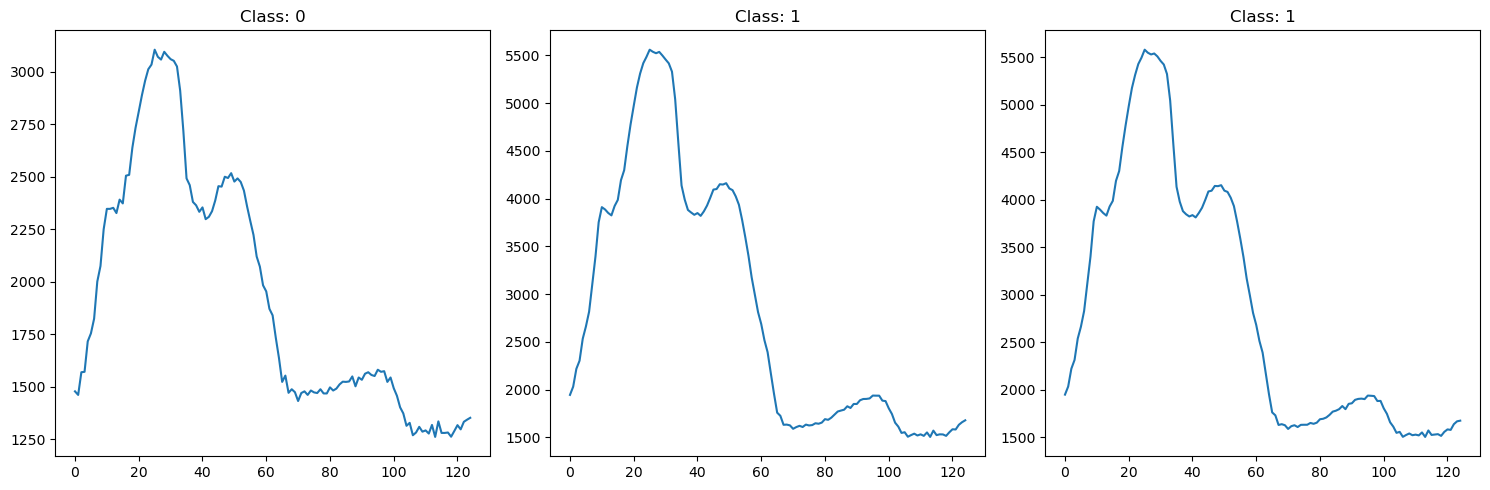

In [19]:
plot_batch_nir_data(nir_data_loader)

In [20]:
def nir_augment_batch(batch, dataset: torch.utils.data.Dataset,weighted_sum: bool = True, roll: bool = True, roll_factor: int = 12, slope: bool = True, 
        slope_factor: float = 0.2, noise: bool = True, noise_range: tuple = (80, 100)):
    
    batch_size = len(batch)
    batch_samples = torch.stack([a for a, b in batch])
    batch_labels = torch.stack([b for a, b in batch])
    
    batch_samples = batch_samples.numpy().astype("float32")
    batch_labels = batch_labels.numpy().astype("uint8").reshape((batch_size, 1))

    samples = dataset.data.numpy().astype("float32")
    labels = dataset.labels.numpy().astype("uint8").reshape((len(dataset), 1))
    
    
    def _get_random_sample_from_class(label):
        """Extract a random sample from the datas marked as 'label'

        Args:
            label (int): Number that describe the class identifier of data to select

        Returns:
            np.array: Random sample of the 'label' class
        """
        class_indexes = np.where(labels == label)[0]
        CLASS_INDEX = np.random.choice(class_indexes, 1)[0]

        return samples[CLASS_INDEX: CLASS_INDEX + 1]

    def _random_noise(arr):
        """Apply adittive white gaussian noise to 'arr' of magnitued 'noise_range'

        Args:
            arr (np.array): Sample to wich apply the noise

        Returns:
            np.array: Noise 'arr'
        """
        rnd_snr = random.randint(noise_range[0], noise_range[1])
        NOISE_FACTOR = 1 / (10 ** (rnd_snr / 10))

        return arr + np.random.normal(0, NOISE_FACTOR, len(arr))

    def _random_roll(arr):
        """Apply random roll (numpy way to say horizontal shift) to 'arr' of magnitude 'roll_factor'

        Args:
            arr (np.array): Sample to wich apply the roll

        Returns:
            np.array: Random rolled sample
        """

        SHIFT_FACTOR = roll_factor
        random_shift = random.randint(-1 * SHIFT_FACTOR, SHIFT_FACTOR)

        rolled = np.roll(arr, random_shift)
        padded = (
            np.pad(rolled[random_shift:], (random_shift, 0), "edge")
            if random_shift >= 0
            else np.pad(rolled[:random_shift], (0, abs(random_shift)), "edge")
        )

        return padded

    def _produce_background_baseline(arr, steps):
        """Apply a random baseline noise to 'arr' of magnitude 'slope_factor' 

        Args:
            arr (np.array): Spectrum to wich apply the baseline noise
            steps (int): Length of the 'arr' argument

        Returns:
            np.array: Noised spectrum
        """

        SLOPE = random.triangular(-1 * slope_factor, slope_factor)
        line = (
            np.linspace(abs(SLOPE), 0, steps)
            if SLOPE < 0
            else np.linspace(0, SLOPE, steps)
        )

        alpha = random.random()

        return arr * alpha + line * (1 - alpha)

    # Apply augmentations
    if weighted_sum:
        alpha = np.random.rand(batch_size)

        other_samples = np.apply_along_axis(
            _get_random_sample_from_class, 1, batch_labels
        ).reshape(batch_size, batch_samples.shape[1])

        if roll:
            other_samples = np.apply_along_axis(
                _random_roll, 1, other_samples)

        batch_samples = (
            np.multiply(
                batch_samples -
                other_samples, alpha.reshape(batch_size, 1)
            )
            + other_samples
        )

    if slope:
        batch_samples = np.apply_along_axis(
            lambda x: _produce_background_baseline(
                x, batch_samples.shape[1]),
            1,
            batch_samples,
        )

    if noise:
        batch_samples = np.apply_along_axis(
            _random_noise, 1, batch_samples)

    batch_samples = torch.from_numpy(batch_samples).type(torch.float32)
    batch_labels = torch.from_numpy(batch_labels.reshape((batch_size,))).type(torch.uint8)
    
    return batch_samples, batch_labels
    

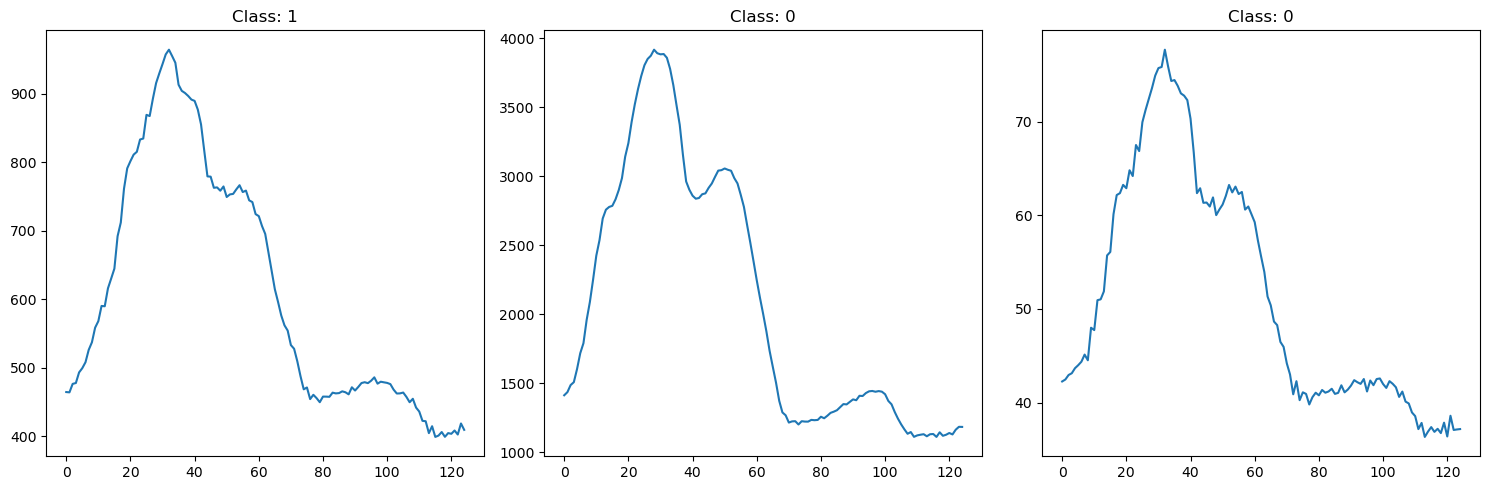

In [22]:
from torch.utils.data import DataLoader

BATCH_SIZE = 3

nir_aug_data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=(lambda batch: nir_augment_batch(batch, dataset = dataset)))
plot_batch_nir_data(nir_aug_data_loader)